## LangGraph Components

In [1]:
!pip install -qU langchain_community langgraph langchain_groq tavily-python

In [2]:
%%capture
!apt-get update
!apt-get install -y graphviz libgraphviz-dev pkg-config
!pip install pygraphviz

In [3]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator

from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults

from IPython.display import Image
import os
from google.colab import userdata

In [4]:
tavily_api_key=userdata.get('tavily_api_key')

In [5]:
os.environ['TAVILY_API_KEY'] = tavily_api_key

In [6]:
tool = TavilySearchResults(max_results=3) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [7]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

> Note: in `take_action` below, some logic was added to cover the case that the LLM returned a non-existent tool name. Even with function calling, LLMs can still occasionally hallucinate. Note that all that is done is instructing the LLM to try again! An advantage of an agentic organization.

In [8]:
class Agent:

    def __init__(self, llm, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("LLM", self.call_openai)
        graph.add_node("Action", self.take_action)
        graph.add_conditional_edges(
            "LLM",
            self.exists_action,
            {True: "Action", False: END}
        )
        graph.add_edge("Action", "LLM")
        graph.set_entry_point("LLM")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.llm = llm.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.llm.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [9]:
groq_api_key=userdata.get('groq_api_key')

In [10]:
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7f9c537741d0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7f9c531527d0>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [11]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

abot = Agent(llm, [tool], system=prompt)

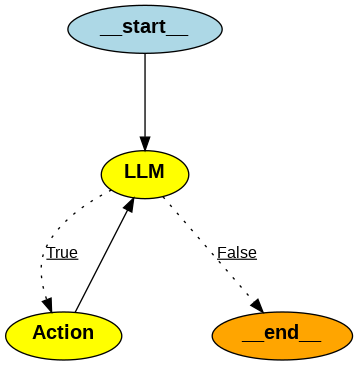

In [12]:

Image(abot.graph.get_graph().draw_png())

In [13]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in sf'}, 'id': 'call_vyx2', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in san francisco '}, 'id': 'call_gskv', 'type': 'tool_call'}
Back to the model!


In [14]:
result

{'messages': [HumanMessage(content='What is the weather in sf?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_vyx2', 'function': {'arguments': '{"query":"weather in sf"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 89, 'prompt_tokens': 1057, 'total_tokens': 1146, 'completion_time': 0.161818182, 'prompt_time': 0.042440212, 'queue_time': 0.022372075999999998, 'total_time': 0.204258394}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4a448ea7-171c-4439-92d2-81a7f057fbb1-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in sf'}, 'id': 'call_vyx2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1057, 'output_tokens': 89, 'total_tokens': 1146}),
  ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'lo

In [15]:
print(result['messages'][-1].content)


The weather in San Francisco is sunny with a high of 57 degrees Fahrenheit and a low of 45 degrees Fahrenheit.


In [16]:
result['messages'][-1].content

'The weather in San Francisco is sunny with a high of 57 degrees Fahrenheit and a low of 45 degrees Fahrenheit.'

In [17]:
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco and Los Angeles'}, 'id': 'call_445w', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles in January 2025'}, 'id': 'call_kxmg', 'type': 'tool_call'}
Back to the model!


In [18]:
result['messages'][-1].content

'The weather in San Francisco in January 2025 is expected to be around 55 degrees Fahrenheit with a mix of sun and clouds. \n\n\n The weather in Los Angeles in January 2025 is expected to be around 64 degrees Fahrenheit with sunny skies.  \n'

In [19]:
result

{'messages': [HumanMessage(content='What is the weather in SF and LA?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_445w', 'function': {'arguments': '{"query":"weather in San Francisco and Los Angeles"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 93, 'prompt_tokens': 1059, 'total_tokens': 1152, 'completion_time': 0.169090909, 'prompt_time': 0.04319521, 'queue_time': 0.021683518, 'total_time': 0.212286119}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-3c1c1b21-e29b-49b8-b18f-eb55eda5a68d-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco and Los Angeles'}, 'id': 'call_445w', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1059, 'output_tokens': 93, 'total_tokens': 1152}),
  ToolMessage(content='[{\'url\': \

In [20]:
import re

content = result['messages'][-1].content
sanitized_content = re.sub(r'`+', '', content).strip()
print("Sanitized Content:", sanitized_content)

Sanitized Content: The weather in San Francisco in January 2025 is expected to be around 55 degrees Fahrenheit with a mix of sun and clouds. 


 The weather in Los Angeles in January 2025 is expected to be around 64 degrees Fahrenheit with sunny skies.


----------------------------------------
- Note, the query was modified to produce more consistent results.
- Results may vary per run and over time as search information and models change.

In [21]:
query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question."
messages = [HumanMessage(content=query)]

abot = Agent(llm, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Who won the super bowl in 2024?'}, 'id': 'call_pn09', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'What state is Kansas City, Missouri located in?'}, 'id': 'call_7vy7', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'What is the GDP of Missouri?'}, 'id': 'call_rkjx', 'type': 'tool_call'}
Back to the model!


In [22]:
print(result['messages'][-1].content)

The Kansas City Chiefs won Super Bowl 2024.  The team is headquartered in Missouri. The GDP of Missouri is $344.12 billion. 

